In [35]:
import matplotlib.pyplot as plt
import time
import numpy as np
from numpy import pi

from qutip import *
from qutip.control import *
from qutip.qip.operations import rx
from qutip.qip.operations import ry
from qutip.qip.operations import rz

from qutip.control.grape import plot_grape_control_fields, _overlap
from qutip.control.cy_grape import cy_overlap
from qutip.control.grape import cy_grape_unitary, grape_unitary_adaptive

from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar
from dataclasses import dataclass
from typing import List, Tuple, Sequence

import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objs as go
import plotly.express as px

from scipy.constants import physical_constants, h

from qutip import jmat, tensor, identity, Qobj

from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar
from qiskit.visualization import plot_state_city
from qiskit.visualization import plot_bloch_multivector

import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Finding Pulse Sequence

In [36]:
# defining starting state, both qutrits in (1 0 0) state to begin with

qubit1state=basis(3, 0)
qubit2state=basis(3, 0)
startingstate=tensor(qubit1state,qubit1state) #initial state
 #when you tensor things together in QuTIP in kepps the dimensions of the original object
#so changing the dims just tells it we can actually use this as a 9x1 and not 2 3x3s.
startingstate.dims=[[9],[1]]
startingstate

Quantum object: dims = [[9], [1]], shape = (9, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

In [37]:
#definiting out unitary transofrmation input as a RX by pi for the first qubit
#to make the dimensions match we have to tensor it with the idetity 

U=tensor(rotation (jmat(1,'x'),pi),identity(3))
U.dims=[[9],[9]]# change dims again
U


Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[ 0.5+0.j          0. +0.j          0. +0.j          0. -0.70710678j
   0. +0.j          0. +0.j         -0.5+0.j          0. +0.j
   0. +0.j        ]
 [ 0. +0.j          0.5+0.j          0. +0.j          0. +0.j
   0. -0.70710678j  0. +0.j          0. +0.j         -0.5+0.j
   0. +0.j        ]
 [ 0. +0.j          0. +0.j          0.5+0.j          0. +0.j
   0. +0.j          0. -0.70710678j  0. +0.j          0. +0.j
  -0.5+0.j        ]
 [ 0. -0.70710678j  0. +0.j          0. +0.j          0. +0.j
   0. +0.j          0. +0.j          0. -0.70710678j  0. +0.j
   0. +0.j        ]
 [ 0. +0.j          0. -0.70710678j  0. +0.j          0. +0.j
   0. +0.j          0. +0.j          0. +0.j          0. -0.70710678j
   0. +0.j        ]
 [ 0. +0.j          0. +0.j          0. -0.70710678j  0. +0.j
   0. +0.j          0. +0.j          0. +0.j          0. +0.j
   0. -0.70710678j]
 [-0.5+0.j          0. +0.j  

In [38]:
#defining constants in hamiltonian

f_fine_structure = 2.87e9
f_nuclear_quadrupole = -5.01e6
f_axial_magnetic_hyperfine = -2.14e6
f_transverse_magnetic_hyperfine = -2.7e6
g_factor_electron = 2.0028
gyromagnetic_constant_nuclear = 1.93297e7 / (2 * np.pi)
uB = physical_constants['Bohr magneton'][0]
uN = physical_constants['nuclear magneton'][0]    
bvector=[0,0,1]

#Defining time steps for GRAPE
T = 1/1800000000
steps=100
times = np.linspace(0, T, steps)

In [39]:


#Defining some terms so the hamiltonian is more clear
#Nuc terms are second qubit, spin=1
#Elec qubit is first qubit, spin=1

nuclear_spin = 1
electron_spin = 1
sigmaxE = jmat(electron_spin,'x')
sigmayE = jmat(electron_spin,'y')
sigmazE = jmat(electron_spin,'z')
sigmaxN = jmat(nuclear_spin,'x')
sigmayN = jmat(nuclear_spin,'y')
sigmazN = jmat(nuclear_spin,'z')
sigmazEsquared = sigmazE*sigmazE
sigmazNsquared = sigmazN*sigmazN
identity3 = identity(3) #3x3 identity matrix



#Creating operators that can be tuned in the Hamiltonian via the control fields, list is below called H_ops

H_opsEx=tensor(sigmaxE, identity3)
H_opsEy=tensor(sigmayE, identity3)
H_opsEz=tensor(sigmazE, identity3)

H_opsNx=tensor(identity3, sigmaxN)
H_opsNy=tensor(identity3, sigmayN)
H_opsNz=tensor(identity3, sigmazN)

H_opsENx = tensor(sigmaxE, sigmaxN)
H_opsENy = tensor(sigmayE, sigmayN)           
H_opsENz = tensor(sigmazE, sigmazN)


#changing dims again

H_opsEx.dims=[[9],[9]]
H_opsEy.dims=[[9],[9]]
H_opsEz.dims=[[9],[9]]

H_opsNx.dims=[[9],[9]]
H_opsNy.dims=[[9],[9]]
H_opsNz.dims=[[9],[9]]

H_opsENx.dims=[[9],[9]]
H_opsENy.dims=[[9],[9]]
H_opsENz.dims=[[9],[9]] 


#making H_ops list, in our system we can only change Ex and Ey so that is the only control terms we are allowing in H_ops           
H_ops = [H_opsEx*(1/T), H_opsEy*(1/T)]#, H_opsEz, H_opsNx, H_opsNy, H_opsNz, H_opsENx, H_opsENy, H_opsENz]            
               
               
#making labels for pulse sequence graphs
H_labels = [r'$uE_{x}$',
            r'$uE_{y}$']
            #r'$uE_{z}$',
            #r'$uN_{x}$',
            ##r'$uN_{y}$',
            #r'$uN_{z}$',
           # r'$uEN_{x}$',
           # r'$uEN_{y}$',
            #r'$uEN_{z}$']


# Defining hamiltonian and constants 

In [40]:
#defining hamiltonian for NV center


#witing out hamiltonian terms

H1 = f_fine_structure * tensor((sigmazEsquared-(2/3)*identity3),identity3)

H2 = f_axial_magnetic_hyperfine * tensor(sigmazE,sigmazN) 

H3 = f_transverse_magnetic_hyperfine * (tensor(sigmaxE,sigmaxN)+tensor(sigmayE,sigmayN))

H4 = f_nuclear_quadrupole * tensor(tensor(identity3), (sigmazNsquared-(2/3)*identity3))

H5 = ((uB/h) * g_factor_electron) * tensor((sigmaxE*bvector[0] + sigmayE*bvector[1] + sigmazE*bvector[2]), identity3)

H6 = gyromagnetic_constant_nuclear * tensor(identity3,(sigmaxN*bvector[0] + sigmayN*bvector[1] + sigmazN*bvector[2]))
          
    
H0= H1+H2 +H3 +H4 +H5 +H6
H0.dims=[[9],[9]] # changing dims again
H0 #full drift hamiltonian 



Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[ 2.89876124e+10  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  2.89916860e+10  0.00000000e+00 -2.70000000e+06
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  2.89857396e+10  0.00000000e+00
  -2.70000000e+06  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00 -2.70000000e+06  0.00000000e+00 -1.91192692e+09
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -2.70000000e+06  0.00000000e+00
  -1.90999333e+09  0.00000000e+00 -2.70000000e+06  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -1.91807975e+09  0.00000000e+00 -2.70000000e+06
   0.00000000e+00]
 [ 0

# Plot pulses

In [41]:
##creating initial control pulse values as starting guess for GRAPE

u0 = np.array([np.random.rand(len(times))*T * 2 * pi * 0.005 for _ in range(len(H_ops))]) # sclaed by T so it is in the correct time dimensions

u0 = [np.convolve(np.ones(10) / 10, u0[idx, :], mode='same') for idx in range(len(H_ops))]


In [42]:
#doing GRAPE!
R=400 #number of itterations
result = cy_grape_unitary(U, H0, H_ops, R, times, u_start=u0, eps=2 * pi / T, phase_sensitive=False,
                          progress_bar=TextProgressBar())



10.0%. Run time:  12.65s. Est. time left: 00:00:01:53
20.0%. Run time:  25.01s. Est. time left: 00:00:01:40
30.0%. Run time:  37.48s. Est. time left: 00:00:01:27
40.0%. Run time:  49.80s. Est. time left: 00:00:01:14
50.0%. Run time:  62.12s. Est. time left: 00:00:01:02
60.0%. Run time:  74.95s. Est. time left: 00:00:00:49
70.0%. Run time:  87.51s. Est. time left: 00:00:00:37
80.0%. Run time: 100.22s. Est. time left: 00:00:00:25
90.0%. Run time: 112.89s. Est. time left: 00:00:00:12
Total run time: 125.39s


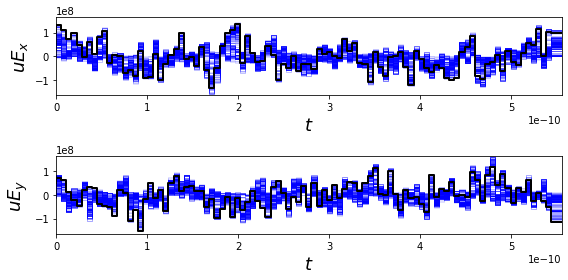

In [43]:
#plotting pulses

plot_grape_control_fields(times, result.u[:, :, :] / (2 * pi), H_labels, uniform_axes=True);
plt.show()

# Calcuate fidelity

In [44]:
#printing ideal final state
idealfinalstate=U*startingstate
print (idealfinalstate)

Quantum object: dims = [[9], [1]], shape = (9, 1), type = ket
Qobj data =
[[ 0.5+0.j        ]
 [ 0. +0.j        ]
 [ 0. +0.j        ]
 [ 0. -0.70710678j]
 [ 0. +0.j        ]
 [ 0. +0.j        ]
 [-0.5+0.j        ]
 [ 0. +0.j        ]
 [ 0. +0.j        ]]


In [45]:
#printing Unitary tranformation according to GRAPE
result.U_f.tidyup(1e-2)

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[-0.30461266-0.46492965j  0.        +0.j          0.        +0.j
   0.41790846-0.58168608j  0.        +0.j          0.        +0.j
   0.40924433+0.10278336j  0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j         -0.30511192-0.46460216j  0.        +0.j
   0.        +0.j          0.41728336-0.58213467j  0.        +0.j
   0.        +0.j          0.4093545 +0.10234369j  0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j         -0.30302165-0.46596817j
   0.        +0.j          0.        +0.j          0.41989436-0.58025419j
   0.        +0.j          0.        +0.j          0.4088906 +0.10418165j]
 [-0.25101519+0.68360267j  0.        +0.j          0.        +0.j
   0.17628012-0.03459038j  0.        +0.j          0.        +0.j
   0.20247408+0.62961243j  0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j         -0.2502807 +0.68387191j  0.        +0.j

In [46]:
#printing real state from final grape

realfinalstate=result.U_f*startingstate
print (realfinalstate)

Quantum object: dims = [[9], [1]], shape = (9, 1), type = ket
Qobj data =
[[-0.30461266-0.46492965j]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [-0.25101519+0.68360267j]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.37482304-0.14226024j]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]]


In [47]:
#finding density matrices and fidelity

idealdensitymatrix=(idealfinalstate * idealfinalstate.dag())#ideal density matrix
densitymatrix=(realfinalstate * realfinalstate.dag())# real density matrix
print (idealdensitymatrix)
print (densitymatrix)
fidelity(idealdensitymatrix,densitymatrix)

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[ 0.25+0.j          0.  +0.j          0.  +0.j          0.  +0.35355339j
   0.  +0.j          0.  +0.j         -0.25+0.j          0.  +0.j
   0.  +0.j        ]
 [ 0.  +0.j          0.  +0.j          0.  +0.j          0.  +0.j
   0.  +0.j          0.  +0.j          0.  +0.j          0.  +0.j
   0.  +0.j        ]
 [ 0.  +0.j          0.  +0.j          0.  +0.j          0.  +0.j
   0.  +0.j          0.  +0.j          0.  +0.j          0.  +0.j
   0.  +0.j        ]
 [ 0.  -0.35355339j  0.  +0.j          0.  +0.j          0.5 +0.j
   0.  +0.j          0.  +0.j          0.  +0.35355339j  0.  +0.j
   0.  +0.j        ]
 [ 0.  +0.j          0.  +0.j          0.  +0.j          0.  +0.j
   0.  +0.j          0.  +0.j          0.  +0.j          0.  +0.j
   0.  +0.j        ]
 [ 0.  +0.j          0.  +0.j          0.  +0.j          0.  +0.j
   0.  +0.j          0.  +0.j          0.  +0.j          0.  +0.j
   0.

0.8901098049371154